In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fxpmath import Fxp
from scipy.signal import sawtooth

def butterfly(a, b):
    """Basic butterfly operation for FFT."""
    return a + b, a - b

def generate_signal(signal_type, N, Fs):
    t = np.arange(N) / Fs
    x_real = np.zeros(N)
    x_imag = np.zeros(N)
    if signal_type == 'sin':
        F1 = 12.5e6
        x_real = np.sin(2 * np.pi * F1 * t)
    elif signal_type == 'pulse':
        x_real[0:2] = 1.0
    elif signal_type == 'random':
        x_real = 2 * np.random.rand(N) - 1
        x_imag = 2 * np.random.rand(N) - 1  
    elif signal_type == 'two_signals':
        F1 = 12.5e6
        F2 = 25e6
        signal = np.sin(2 * np.pi * F1 * t) + np.sin(2 * np.pi * F2 * t)
        x_real = signal / np.max(np.abs(signal))
    elif signal_type == 'sawtooth':
        F1 = 12.5e6
        signal = sawtooth(2 * np.pi * F1 * t)
        x_real = signal / np.max(np.abs(signal))
    else:
        print(f"Warning: Signal type '{signal_type}' not recognized. Generating zeros.")
        x_real = np.zeros(N)
    return x_real + 1j * x_imag

def fft_8p_fxp(arr_fxp):
    FXP_FORMAT_TW = 'fxp-s10/9'
    FXP_FORMAT_STAGES_8P = ['fxp-s12/7', 'fxp-s13/7', 'fxp-s14/7']
    tw_float = np.exp(-2j * np.pi * np.arange(4) / 8)
    tw = Fxp(tw_float, dtype=FXP_FORMAT_TW)
    st1_vals = np.empty(8, dtype=complex)
    for i in range(4):
        a, b = butterfly(arr_fxp[i], arr_fxp[i+4])
        st1_vals[i], st1_vals[i+4] = a.get_val(), b.get_val()
    st1_vals[4] *= tw[0].get_val(); st1_vals[5] *= tw[1].get_val()
    st1_vals[6] *= tw[2].get_val(); st1_vals[7] *= tw[3].get_val()
    st1 = Fxp(st1_vals, dtype=FXP_FORMAT_STAGES_8P[0])
    st2_vals = np.empty(8, dtype=complex)
    for i in range(2):
        a, b = butterfly(st1[i], st1[i+2])
        c, d = butterfly(st1[i+4], st1[i+6])
        st2_vals[i], st2_vals[i+2] = a.get_val(), b.get_val()
        st2_vals[i+4], st2_vals[i+6] = c.get_val(), d.get_val()
    st2_vals[3] *= -1j; st2_vals[7] *= -1j
    st2 = Fxp(st2_vals, dtype=FXP_FORMAT_STAGES_8P[1])
    st3_vals = np.empty(8, dtype=complex)
    for i in range(4):
        idx1, idx2 = i * 2, i * 2 + 1
        a, b = butterfly(st2[idx1], st2[idx2])
        st3_vals[idx1], st3_vals[idx2] = a.get_val(), b.get_val()
    st3 = Fxp(st3_vals, dtype=FXP_FORMAT_STAGES_8P[2])
    bit_rev = [0, 4, 2, 6, 1, 5, 3, 7]
    return st3[bit_rev]

In [ ]:
N = 32
Fs = 32e6
selected_signal_type = 'sin'
input_signal_float = generate_signal(selected_signal_type, N, Fs)
fft_numpy_reference = np.fft.fft(input_signal_float)

Generated signal of type: 'sin'
Input Signal Shape: (32,)


In [ ]:
FXP_FORMAT_INPUT_32P = 'fxp-s8/7'
FXP_FORMAT_A_VECTORS = 'fxp-s10/7'
FXP_FORMAT_TWIDDLES = 'fxp-s10/7'
FXP_FORMAT_PIPELINE_INPUT = 'fxp-s10/7'

In [ ]:
def mixed_radix_4x8_fft_fxp(signal_fxp_32p):
    N = 32
    N_quarter = N // 4
    a = [np.empty(N_quarter, dtype=complex) for _ in range(4)]
    j_fxp = Fxp(1j, like=signal_fxp_32p[0])
    for n in range(N_quarter):
        s0, s1, s2, s3 = (signal_fxp_32p[n], 
                          signal_fxp_32p[n + N_quarter], 
                          signal_fxp_32p[n + 2*N_quarter], 
                          signal_fxp_32p[n + 3*N_quarter])
        y0_temp, y1_temp = s0 + s2, s1 + s3
        y2_temp, y3_temp = s0 - s2, s1 - s3
        y0 = y0_temp + y1_temp
        y1 = y2_temp - j_fxp * y3_temp
        y2 = y0_temp - y1_temp
        y3 = y2_temp + j_fxp * y3_temp
        a[0][n] = Fxp(y0, dtype=FXP_FORMAT_A_VECTORS).get_val()
        a[1][n] = Fxp(y1, dtype=FXP_FORMAT_A_VECTORS).get_val()
        a[2][n] = Fxp(y2, dtype=FXP_FORMAT_A_VECTORS).get_val()
        a[3][n] = Fxp(y3, dtype=FXP_FORMAT_A_VECTORS).get_val()

    a_fxp = [Fxp(vec, dtype=FXP_FORMAT_A_VECTORS) for vec in a]
    p_in = []
    p_in.append(a_fxp[0])
    for r in range(1, 4):
        tw_vals = np.exp(-2j * np.pi * r * np.arange(N_quarter) / N)
        tw_fxp = Fxp(tw_vals, dtype=FXP_FORMAT_TWIDDLES)
        product = a_fxp[r] * tw_fxp
        p_in_r = Fxp(product, dtype=FXP_FORMAT_PIPELINE_INPUT)
        p_in.append(p_in_r)
    Y_fxp = [fft_8p_fxp(p) for p in p_in]
    X_final = np.empty(N, dtype=complex)
    Y_numpy = [y.get_val() for y in Y_fxp]
    for r in range(4):
        for m in range(N_quarter):
            X_final[4*m + r] = Y_numpy[r][m]
    return Fxp(X_final, like=Y_fxp[0])

input_signal_fxp_32p = Fxp(input_signal_float, dtype=FXP_FORMAT_INPUT_32P)
final_model_output_fxp = mixed_radix_4x8_fft_fxp(input_signal_fxp_32p)

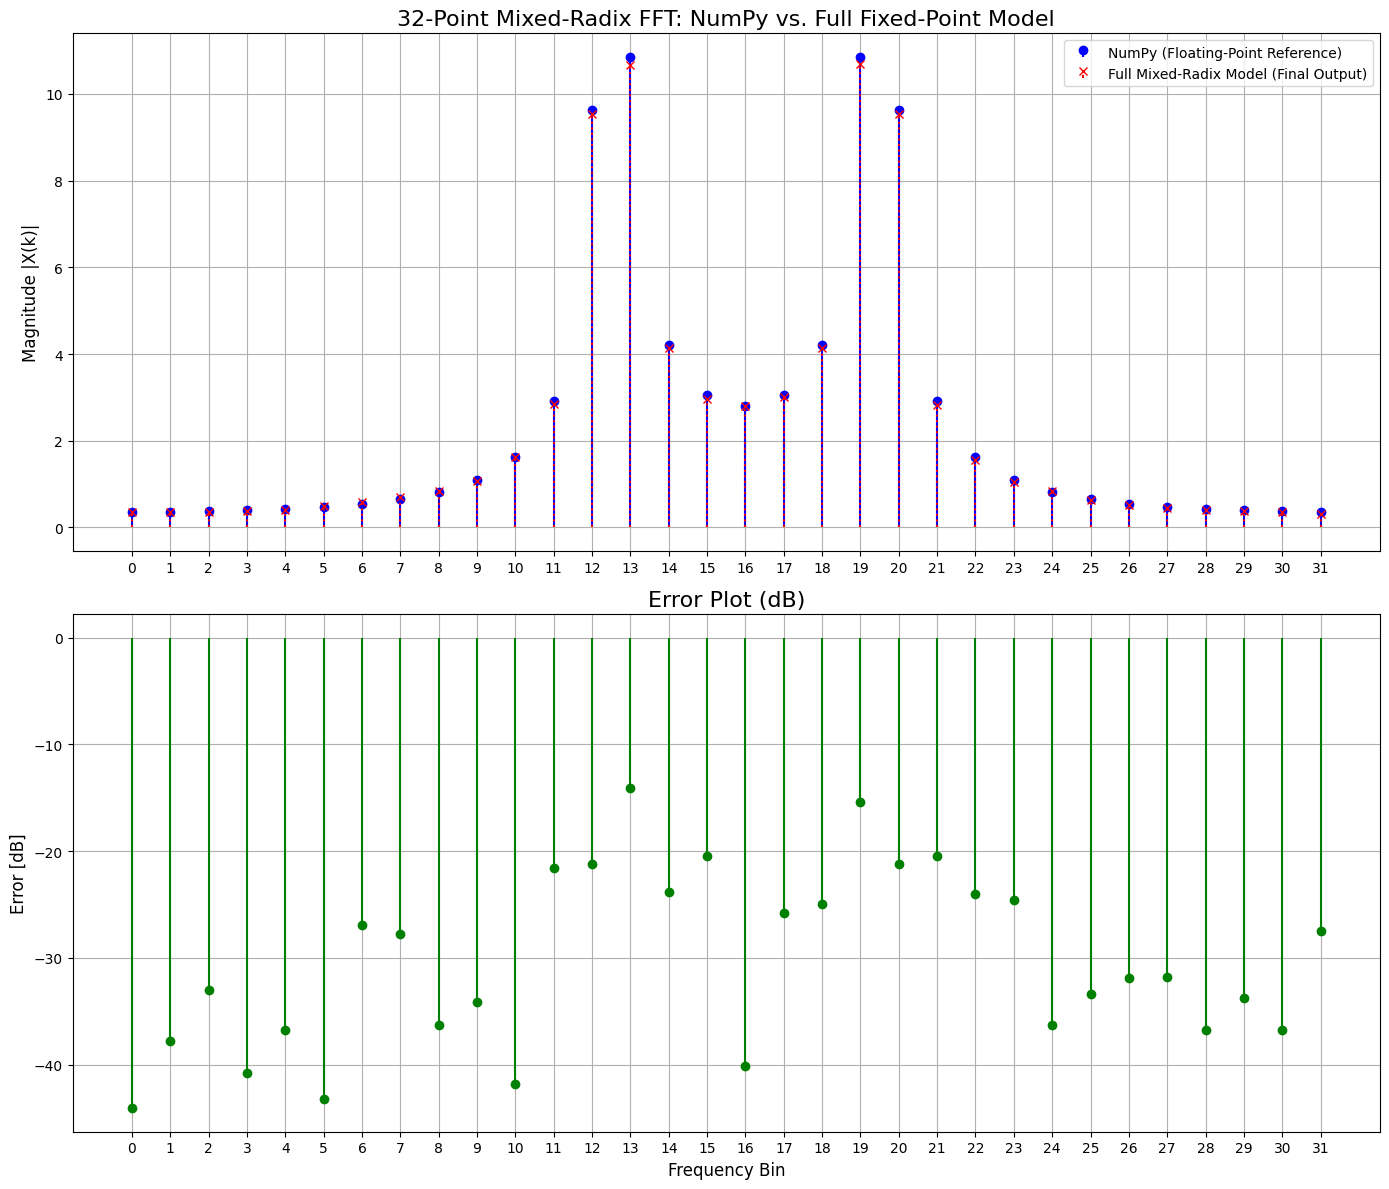


The Mean Squared Error (MSE) between NumPy and the full model is: 0.004233


In [ ]:
final_fxp_numpy = final_model_output_fxp.get_val()
freq_bins = np.arange(N)
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

axs[0].set_title('Comparison FFT: NumPy vs. Mixed-radix', fontsize=16)

axs[0].stem(freq_bins, np.abs(fft_numpy_reference), 
            linefmt='b-', markerfmt='bo', basefmt=' ', 
            label='NumPy (Floating-Point Reference)')

axs[0].stem(freq_bins, np.abs(final_fxp_numpy), 
            linefmt='r:', markerfmt='rx', basefmt=' ',
            label=f'Full Mixed-Radix Model (Final Output)')

axs[0].set_ylabel('Magnitude |X(k)|', fontsize=12)
axs[0].set_xticks(freq_bins)
axs[0].legend()
axs[0].grid(True)

error_vector = fft_numpy_reference - final_fxp_numpy
epsilon = 1e-12 
error_magnitude_db = 20 * np.log10(np.abs(error_vector) + epsilon)

axs[1].set_title('Error Plot (dB)', fontsize=16)
axs[1].stem(freq_bins, error_magnitude_db, 
            linefmt='g-', markerfmt='go', basefmt=' ')

axs[1].set_xlabel('Frequency Bin', fontsize=12)
axs[1].set_ylabel('Error [dB]', fontsize=12)
axs[1].set_xticks(freq_bins)
axs[1].grid(True)

plt.tight_layout()